## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. 

Each measurement (i.e. each row) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. 

Each TDC count correspond 25/30 ns, whereas the BX_COUNTER features gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. 

You can see these way of storing the time as similar to hours, minutes and seconds.

1\. Create a Pandas DataFrame by read N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the value of 'x'

3\. Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset

4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

6\. Create a new DataFrame with only the rows with HEAD=1

7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EX 1

In [3]:
N = 20000
file_name = "/home/spiro/home/perina/data/data_000637.txt"
data = pd.read_csv(file_name, nrows=N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
5,1,0,63,3869200167,2762,4
6,1,0,61,3869200167,2772,14
7,1,0,139,3869200167,2776,0
8,1,0,62,3869200167,2774,21
9,1,0,60,3869200167,2788,7


# EX 2

In [4]:

x = data['BX_COUNTER'].max()-data['BX_COUNTER'].min()+1
print(x)

3564


# EX 3

In [5]:

data_tot = pd.read_csv(file_name)
data_tot['timens']=data_tot['ORBIT_CNT']*x*25+data_tot['TDC_MEAS']*25/30+data_tot['BX_COUNTER']*25

tot_time = data_tot['timens'].max()-data_tot['timens'].min()
print(tot_time*1e-9, 'seconds')



0.980416253313 seconds


# EX 4

In [6]:
data_tot

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timens
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
5,1,0,63,3869200167,2762,4,3.447457e+14
6,1,0,61,3869200167,2772,14,3.447457e+14
7,1,0,139,3869200167,2776,0,3.447457e+14
8,1,0,62,3869200167,2774,21,3.447457e+14
9,1,0,60,3869200167,2788,7,3.447457e+14


# EX 5

In [7]:
data_rand = data.copy()
data_rand['HEAD'] = np.random.randint(0,2, len(data.HEAD))
data_rand

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,0,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,0,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
5,0,0,63,3869200167,2762,4
6,1,0,61,3869200167,2772,14
7,1,0,139,3869200167,2776,0
8,0,0,62,3869200167,2774,21
9,1,0,60,3869200167,2788,7


# EX 6

In [8]:
data_1 = data_rand[data_rand.HEAD == 1]
data_1

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
2,1,0,63,3869200167,2553,28
4,1,0,64,3869200167,2760,25
6,1,0,61,3869200167,2772,14
7,1,0,139,3869200167,2776,0
9,1,0,60,3869200167,2788,7
11,1,0,64,3869200167,2786,19
12,1,1,6,3869200167,2792,18
13,1,0,36,3869200167,2791,23
14,1,0,56,3869200167,2789,3


# EX 7

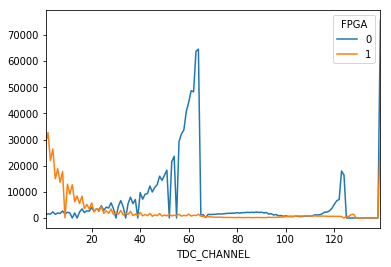

In [9]:
datachan = data_tot.groupby(['FPGA','TDC_CHANNEL']).sum()
#print(datachan)

datachan.unstack('FPGA')['HEAD'].fillna(value=0).plot()




plt.show()
#print(datachan.unstack('FPGA')['HEAD'])

# EX 8

In [64]:
datanoise = data_tot.groupby(['FPGA','TDC_CHANNEL']).sum()

dn1 = data_tot[data_tot['FPGA'] == 1].groupby(['TDC_CHANNEL']).sum()
dn0 = data_tot[data_tot['FPGA'] == 0].groupby(['TDC_CHANNEL']).sum()

num_noise = 3

noisy = pd.DataFrame([datanoise['HEAD'].nlargest(num_noise).index]).T

#noisy1 = [dn1['HEAD'].nlargest(num_noise).index for i in range(num_noise)]
#noisy0 = [dn0['HEAD'].nlargest(i+1).index for i in range(num_noise)]
#print(noisy0)
#print(noisy1)

noisy.rename(columns = {0: '(FPGA, TDC_CHAN)'})

,"(FPGA, TDC_CHAN)"
0,"(0, 139)"
1,"(0, 64)"
2,"(0, 63)"


# EX 9

In [82]:
#grouping by orbit count

num_orb = data_tot.groupby('ORBIT_CNT').sum()['HEAD']
#print(num_orb)

#meaning number of orbits which appear only once in the database

un_orb = num_orb[num_orb == 1]
print('Number of unique orbits: ',un_orb.sum()) 

#meaning the number of distinct orbits

dist_orb = num_orb.count()
print('Number of distinct orbits: ',dist_orb) 

#counts from 139
data_139 = data_tot[data_tot['TDC_CHANNEL'] == 139].groupby('ORBIT_CNT').sum()['HEAD']
dist_orb_139 = data_139.count()
print('Number of distinct orbits having at least one count from TDC_CHANNEL 139: ',dist_orb_139)

Number of unique orbits:  2
Number of distinct orbits:  11001
Number of distinct orbits having at least one count from TDC_CHANNEL 139:  10976
